In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Parâmetros iniciais
nIterations = 2e3
fs          = 1e6   # Frequência de amostragem
y_ppm       = 50    # Frequência de offset ppm
f0          = 1e3   # Clock nominal (frequência)
pn_var      = 1e-9  # Variância do ruído
Kp          = 0.5  # Constante proporcional
Ki          = 0.1  # Constante Integral
pd_choice   = 0    # Escolha de detector de fase (0 -> arctan{.}; 1 -> Im{.})

In [3]:
# Parâmetros derivados
y        = y_ppm * 1e-6;  # Fractional frequency offset in ppm
f_offset = y * f0;        # Absolute freq error (in Hz)
F_offset = f_offset/fs;   # Normalized absolute frequency offset

In [4]:
# Nominal phase incremet
delta_phi_c = 2*np.pi*f0/fs
print(delta_phi_c)

0.006283185307179586


In [7]:
# Sinal de entrada

# O sinal é uma senoide complexa. 

delta_phi_in = 2*np.pi*(f0  + f_offset)/fs # Incremento para a fase da exponencial

phase_noise  = 0 #np.sqrt(pn_var)*np.random.randn(int(nIterations)) # Ruído de fase

phi_in       = np.arange(nIterations)*delta_phi_in + phase_noise # Fase instantânea

s_in = np.exp(1j * (phi_in + 1)) # Sinal de entrada com atraso 

c:\Users\Leoni Gabriel\radioconda\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\Leoni Gabriel\radioconda\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


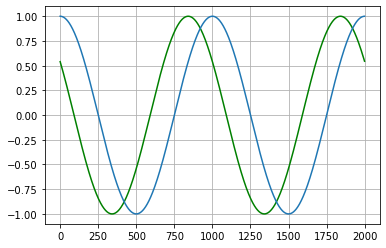

In [8]:
s_comp = np.exp(1j * (phi_in)) #sinal comparativo com fase original e sem atraso em relação ao sinal recebido pelo DLL 
plt.plot(s_in, "g", label='S_in')
plt.plot(s_comp, label='Referência')
plt.grid()
plt.show()

In [12]:
# prealocações
s_loop             = np.zeros(int(nIterations), dtype=complex) # É a tentativa de acerto para a fase
phi_loop           = np.zeros(int(nIterations)) # Acumulador de fase, é a fase da saída
dds_mult           = np.zeros(int(nIterations),dtype=complex) # Recebe a multiplicação entre a fase da entrada e a o conjugado da saída
phi_error          = np.zeros(int(nIterations)) # Erro entre as diferenças de fase
phi_error_filtered = np.zeros(int(nIterations)) # Erro após o controlador PI

In [13]:
#Inicialização com alguma fase randômica e incialização da integral em 0 
phi_loop.put(0,np.sqrt(np.pi)*np.random.randn(1))
integral_out = 0

In [14]:
for ii in range(int(nIterations)-1):

  s_loop.put(ii,np.exp(1j*phi_loop.item(ii)))

  # Detector de fase 
  # Multiplica o sinal de entrada com o conjugado da tentativa de fase
  dds_mult.put(ii, s_in.item(ii) * np.conjugate(s_loop.item(ii)))

  # Erro em fase
  if (pd_choice == 1):
    phi_error.put(ii, np.imag(dds_mult.item(ii)))
  else:
    phi_error.put(ii, np.angle(dds_mult.item(ii)))

  # Filtro do loop
  # Aqui começa o controlador PI

  # Termo proporcional
  proportional_out = phi_error.item(ii)*Kp
  
  # Termo integral, que leva em conta os erros anteriores para acertar o estado estacionário
  integral_out     = phi_error.item(ii)*Ki + integral_out
 
  # Saída do controlador PI
  phi_error_filtered.put(ii, proportional_out + integral_out)

  # Atualização do acumulador de fase
  phi_loop.put(ii+1, phi_loop.item(ii) + delta_phi_c + phi_error_filtered.item(ii))


In [16]:
# Erro teórico para o estado estacionário
if (Ki == 0):
    phi_error_ss_expected = 2*np.pi * F_offset / Kp;
else:
    phi_error_ss_expected = 0;

phi_error_filtered_ss_expected = 2*np.pi * F_offset
print(phi_error_filtered_ss_expected)

3.141592653589793e-07


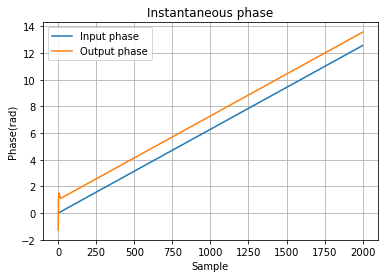

In [17]:
# Plot das fases
plt.plot(phi_in, label = 'Input phase')
plt.legend()
plt.plot(phi_loop, label = 'Output phase')
plt.legend()
plt.title('Instantaneous phase')
plt.xlabel('Sample')
plt.ylabel('Phase(rad)')
plt.grid()
plt.show()

c:\Users\Leoni Gabriel\radioconda\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\Leoni Gabriel\radioconda\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\Leoni Gabriel\radioconda\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


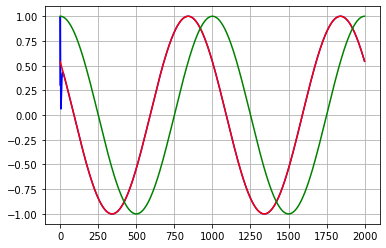

In [20]:
#Plot dos sinais
s_out = np.exp(1j * phi_loop)
plt.plot(s_out,"b", label= 'saída')
plt.plot(s_in, "r")
plt.plot(s_comp, "g")
plt.grid()
plt.show()

c:\Users\Leoni Gabriel\radioconda\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


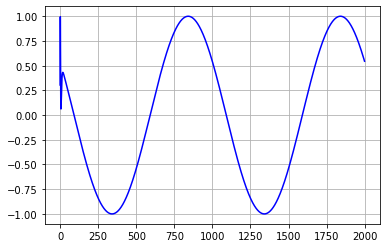

In [19]:
#plot do sinal de saída
plt.plot(s_out,"b")
plt.grid()
plt.show()